In [96]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import log_loss

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

In [87]:
class LogisticRegressionClassifier:
    def __init__(self, degree=2, max_iter=10000, tol=0.001):
        self.degree = degree
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.classes = None
        self.cls_one_hot_encoding = None  # ground truth

    def predict(self, X):
        y_head = self._sigmoid(self.weights, X)
        prob = self._softmax(y_head.T)
        pred = np.argmax(prob, axis=1)  #Get Index (class) with highest score
        return pred

    def fit(self, X, y):
        # Train the model
        self.classes = np.sort(np.unique(y))  # ascending order
        self._init_weights(self.classes.shape[0], X.shape[1])  # Shape of (number of classes, number of features). Every class has his own weights vector
        self._create_label_matrix(y)

        # cls_one_hot_encoding (150,3) X.shape=(150,4)
        cost_list = []
        for _ in range(self.max_iter):
            y_head = self._sigmoid(self.weights, X)  # (3,150)
            prob = self._softmax(y_head.T)  # Row vector corresponds to the probability distribution for one sample (150,3)
            loss = self._log_loss(prob)

            self.weights = self.weights - self.tol * ((y_head - self.cls_one_hot_encoding.T) @ X) ### ??? Shapes... weights = (3,4) - (matrix with 3,4)
            cost_list.append(loss)
        return cost_list

    def _sigmoid(self, w, X):
        Z = np.float64(w @ X.T)
        y_head = 1 / (1 + np.exp(-Z))
        return y_head
    
    # https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
    def _softmax(self, y_head):
        assert len(y_head.shape) == 2
        s = np.max(y_head, axis=1)
        s = s[:, np.newaxis] # necessary step to do broadcasting. Transform array into next dimension as column vector
        e_x = np.exp(y_head - s)
        div = np.sum(e_x, axis=1)
        div = div[:, np.newaxis]
        return e_x / div

    def _log_loss(self, prob):
        # label matrix 
        L = np.multiply(self.cls_one_hot_encoding, np.log(prob))
        log_loss = -(np.sum(L)) / len(self.cls_one_hot_encoding)
        return log_loss

    def _create_label_matrix(self, y):
        #print("Classes: ", self.classes)
        self.cls_one_hot_encoding = np.zeros((len(y), len(self.classes)))  # (150, 3)
        for i, label in enumerate(y):
            self.cls_one_hot_encoding[i][label] = 1

    def _init_weights(self, num_cls, num_feat):
        self.weights = abs(np.random.randn(num_cls, num_feat))
        #print("Init Weights: \n", self.weights)
        

In [88]:
#X, y = load_iris(return_X_y=True)
vegi_df = pd.read_csv("G:/Meine Ablage/KI_Projekt/Daten/vegis_all.csv")
vegi_df = vegi_df.drop(columns=["Unnamed: 0", "green pixels"])
vegi_df.head(10)

,Hight,Width,R,G,B,green onion pixels,ratio area,circularity,keypoints,mean keypoints,Label,Image
0,191,85,141,117,91,0,0.729042,0.574953,40,11.697907,Kartoffel,Kartoffel_1
1,193,80,141,117,91,0,0.751392,0.566709,41,11.196103,Kartoffel,Kartoffel_2
2,194,78,141,117,91,0,0.775938,0.583498,35,12.240883,Kartoffel,Kartoffel_3
3,155,67,136,112,84,0,0.748387,0.649936,40,6.705826,Kartoffel,Kartoffel_4
4,166,68,136,112,84,0,0.694454,0.562511,40,6.861728,Kartoffel,Kartoffel_5
5,168,68,136,112,84,0,0.713323,0.578262,41,7.037449,Kartoffel,Kartoffel_6
6,150,130,136,112,84,0,0.800256,0.674584,49,8.504246,Kartoffel,Kartoffel_7
7,148,126,119,95,72,0,0.811937,0.823492,47,8.894188,Kartoffel,Kartoffel_8
8,147,125,119,95,72,0,0.810803,0.835890,52,8.337561,Kartoffel,Kartoffel_9
9,181,131,115,90,69,0,0.763253,0.756819,34,9.984699,Kartoffel,Kartoffel_10


In [89]:
vegi_encoded_df = vegi_df.copy()

vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Karotte', 'Label'] = 0
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Kartoffel', 'Label'] = 1
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Zwiebel', 'Label'] = 2
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Karotte_Trieb', 'Label'] = 3
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Kartoffel_Trieb', 'Label'] = 4
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Zwiebel_Trieb', 'Label'] = 5

vegi_encoded_df['Label'] = vegi_encoded_df['Label'].astype('int')
print(vegi_encoded_df['Label'].value_counts())

X = vegi_encoded_df.iloc[:, 0:10]
y = vegi_encoded_df.iloc[:, 10:12]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Image names are only for assignment from datapoint to corresponding image
image_names = y_train.iloc[:,1]  
image_names_test = y_test.iloc[:,1]

y_train_clean = y_train.drop(columns="Image")
y_test_clean = y_test.drop(columns="Image")

print(X_train.shape)
print(X_test.shape)

# Scaler
X_train_copy = X_train.copy()

col_names = ['Hight', 'Width', 'R', 'G', 'B', 'green onion pixels', 'ratio area', 'circularity', 'keypoints', 'mean keypoints']
features = X_train_copy[col_names]

ct = ColumnTransformer([
        ('standard1', StandardScaler(), ['Hight', 'Width', 'R', 'G', 'B', 'green onion pixels'])
    ], remainder='passthrough')

X_train_scaled = ct.fit_transform(features)

# Scale Testdata
col_names = ['Hight', 'Width', 'R', 'G', 'B', 'green onion pixels', 'ratio area', 'circularity', 'keypoints', 'mean keypoints']
features_test = X_test[col_names]
X_test_scaled = ct.transform(features_test)

Label
3    1632
1    1221
0    1056
2    1003
4     822
5     780
Name: count, dtype: int64
(4885, 10)
(1629, 10)


In [90]:
"""
print(X_train.head())
print(X_test.head())
print(y_train_clean.head())
print(y_test_clean.head())
print(image_names.head())
"""

'\nprint(X_train.head())\nprint(X_test.head())\nprint(y_train_clean.head())\nprint(y_test_clean.head())\nprint(image_names.head())\n'

In [91]:
clf = LogisticRegressionClassifier(tol=30000)
X_train_scaled_transformed = PolynomialFeatures(degree=2).fit_transform(X_train_scaled)
y_train_clean_2 = y_train_clean.to_numpy()


In [92]:
loss_list = clf.fit(X_train_scaled_transformed, y_train_clean_2)


C:\Users\Leon\AppData\Local\Temp\ipykernel_11004\2345023760.py:35: RuntimeWarning: overflow encountered in exp
  y_head = 1 / (1 + np.exp(-Z))


In [85]:
loss_list

[1.7915420575080017,
 1.7917594692280552,
 1.781538159711966,
 1.776516054991139,
 1.7710389829487903,
 1.7675043891349476,
 1.7644748144487938,
 1.7590778565486065,
 1.6729352196024851,
 1.771392712270162,
 1.7659535312511387,
 1.760865623063381,
 1.7623719524882753,
 1.756964162697639,
 1.7589485069999546,
 1.7452813266551384,
 1.7047888774612447,
 1.7703477511386996,
 1.7584831843406437,
 1.7544681138906155,
 1.7601247937809865,
 1.7568994076567592,
 1.7538150165557722,
 1.747336715415993,
 1.7088147871595618,
 1.7762545550672297,
 1.7772446289915216,
 1.7990068938102315,
 1.8303971444979457,
 1.76528068089426,
 1.7790401527983146,
 1.7529208596411803,
 1.7815303879372708,
 1.7613625961911061,
 1.7497568996791888,
 1.748423411870062,
 1.7464551482590192,
 1.7429393441967687,
 1.7373734903064442,
 1.7248331243722699,
 1.69555153507537,
 1.6573515536915409,
 1.6831373963259264,
 1.7625042335299137,
 1.7505765705016574,
 1.7492419502975667,
 1.74730551558614,
 1.7423628269449776,
 1.73

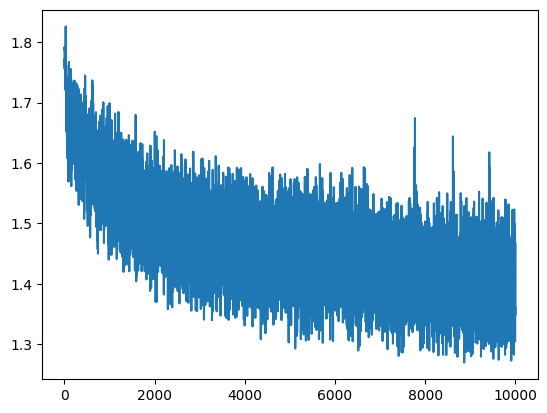

In [100]:
x_ = [i for i in range(len(loss_list))]
plt.plot(x_, loss_list)
plt.show()

In [93]:
y_train_pred = clf.predict(X_train_scaled_transformed)
X_test_scaled_transformed = PolynomialFeatures(degree=2).fit_transform(X_test_scaled)
y_test_pred = clf.predict(X_test_scaled_transformed)

accuracy_testdata = accuracy_score(y_test_clean, y_test_pred)
accuracy_traindata = accuracy_score(y_train_clean, y_train_pred)
print(f"Accuracy Test: {accuracy_testdata}\nAccuracy Train: {accuracy_traindata}")

number_correct_testdata = accuracy_score(y_test_clean, y_test_pred, normalize=False)
number_correct_traindata = accuracy_score(y_train_clean, y_train_pred, normalize=False)
print(f"Number Correct Predicions Test: {number_correct_testdata}\nNumber Correct Predicions Train: {number_correct_traindata}")

Accuracy Test: 0.61817065684469
Accuracy Train: 0.611668372569089
Number Correct Predicions Test: 1007
Number Correct Predicions Train: 2988


C:\Users\Leon\AppData\Local\Temp\ipykernel_11004\2345023760.py:35: RuntimeWarning: overflow encountered in exp
  y_head = 1 / (1 + np.exp(-Z))
C:\Users\Leon\AppData\Local\Temp\ipykernel_11004\2345023760.py:35: RuntimeWarning: overflow encountered in exp
  y_head = 1 / (1 + np.exp(-Z))


Vegis
[[194  34  15   8   4  12]
 [ 10 294   0   0   0   2]
 [ 18 131  97   0  12   2]
 [ 41  25   0 329   0   8]
 [  1 178   0   0  12   0]
 [ 70  10   2  19  20  81]]


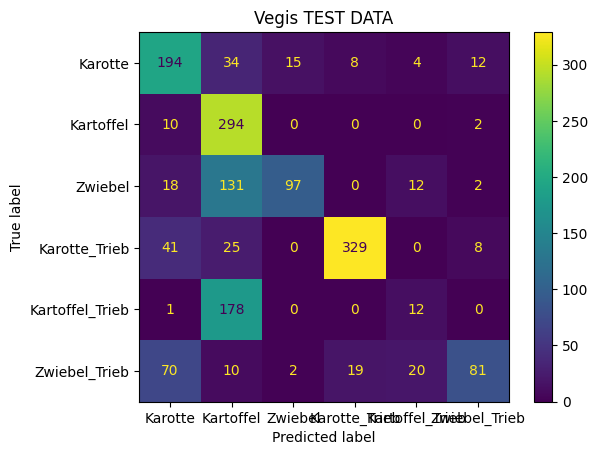

In [94]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_clean,
    y_test_pred,
    display_labels=['Karotte', 'Kartoffel', 'Zwiebel', 'Karotte_Trieb', 'Kartoffel_Trieb', 'Zwiebel_Trieb'],
    cmap='viridis',
    normalize=None,
)
disp.ax_.set_title("Vegis TEST DATA")

print("Vegis")
print(disp.confusion_matrix)

Vegis
[[ 563  126   27   22    7   44]
 [  23  889    0    0    0    3]
 [  61  383  247    0   48    4]
 [ 114   73    0 1027    0   15]
 [   0  605    0    0   26    0]
 [ 187   38   11   53   53  236]]


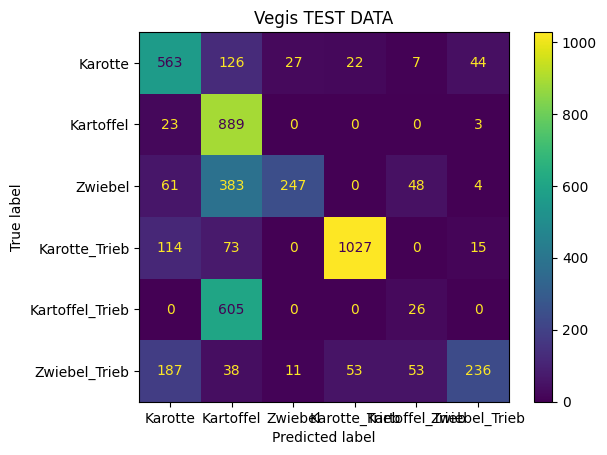

In [95]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_train_clean,
    y_train_pred,
    display_labels=['Karotte', 'Kartoffel', 'Zwiebel', 'Karotte_Trieb', 'Kartoffel_Trieb', 'Zwiebel_Trieb'],
    cmap='viridis',
    normalize=None,
)
disp.ax_.set_title("Vegis TEST DATA")

print("Vegis")
print(disp.confusion_matrix)

In [14]:
#Debugging
def softmax(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    #print("s max: ", s)
    s = s[:, np.newaxis] # necessary step to do broadcasting. Transform array into next dimension as column vector
    #print("s new: ", s)
    e_x = np.exp(z - s)
    #print("e_x", e_x)
    div = np.sum(e_x, axis=1)
    #print("div sum", div)
    div = div[:, np.newaxis] # dito
    #print("div", div)
    return e_x / div

def sigmoid(w, X):
    Z = w @ X.T
    y_head = 1 / (1 + np.exp(-Z))
    return y_head

weights = abs(np.random.randn(3, 4))
y_head = sigmoid(weights, X)
print(y_head.shape)
prob = softmax(y_head.T)
prob.shape


[[0.00626879 0.01704033 0.04632042 0.93037047]
 [0.01203764 0.08894682 0.24178252 0.65723302]
 [0.00626879 0.01704033 0.04632042 0.93037047]
 [0.         0.         1.         0.        ]]
Summe:  1.0
